# Cancer Detection Mini-Project


## Introduction
In this competition, we are asked to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.

### Dataset
The training dataset is composed of 220,025 images, each labeled as either containing metastatic cancer cells or not (binary labeling). The dimensions of each image are 96x96 pixels, and they include three color channels: red, green, and blue. Within the dataset, there are 130,908 images classified as negative and 89,117 classified as positive.

The test dataset contains 57,458 images that are unlabeled but have the same dimensions as those in the training set.

## Initialization
We will install and import the necessary libraries, verify the environment setup, and download the dataset.

In [2]:
!pip install -q kaggle matplotlib seaborn

In [3]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
import pandas as pd
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

2024-04-23 14:59:37.011250: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 14:59:37.011284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 14:59:37.012418: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 14:59:37.017817: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Verify GPUs are available
print("TensorFlow version:", tf.__version__)
print("Number of available GPUs:", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs.")
    except RuntimeError as e:
        print(e)

TensorFlow version: 2.15.0
Number of available GPUs: 2
Memory growth enabled for GPUs.


2024-04-23 14:59:41.370250: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 14:59:41.370478: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 14:59:41.377303: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
home_path = os.environ['HOME']
!cp kaggle.json {home_path}/.kaggle
!chmod 600 {home_path}/.kaggle/kaggle.json

!kaggle competitions download -c histopathologic-cancer-detection

directory_path = './data'
if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"The directory {directory_path} has been deleted.")
else:
    print(f"The directory {directory_path} does not exist.")

!unzip -q histopathologic-cancer-detection.zip -d {directory_path}

histopathologic-cancer-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
The directory ./data has been deleted.


In [5]:
data_path        = './data'
train_path       = './data/train/'
test_path        = './data/test/'
train_label_file = './data/train_labels.csv'
os.listdir(data_path)

['train', 'sample_submission.csv', 'train_labels.csv', 'test']

## Exploratory Data Analysis (EDA)

In [6]:
print("Training Labels")

df = pd.read_csv(train_label_file)
df["file"] = df["id"] + ".tif"
df.head(5)


Training Labels


,id,label,file
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


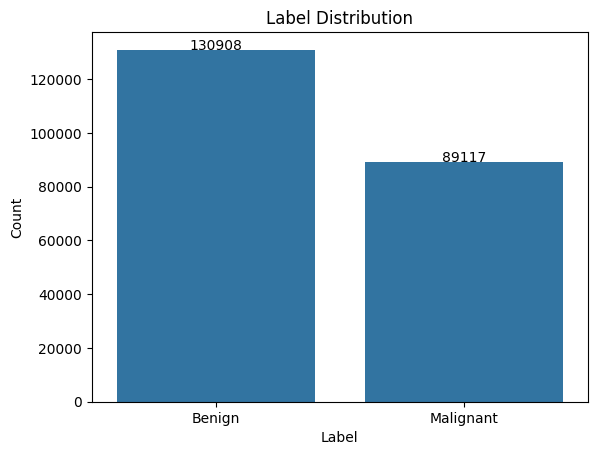

In [7]:
label_counts = df['label'].value_counts()
label_names = {1: 'Malignant', 0: 'Benign'}

sns.barplot(x=[label_names[i] for i in label_counts.index], y=label_counts.values)

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
for i, v in enumerate(label_counts.values):
    plt.text(i, v + 0.1, str(v), ha='center')
plt.show()

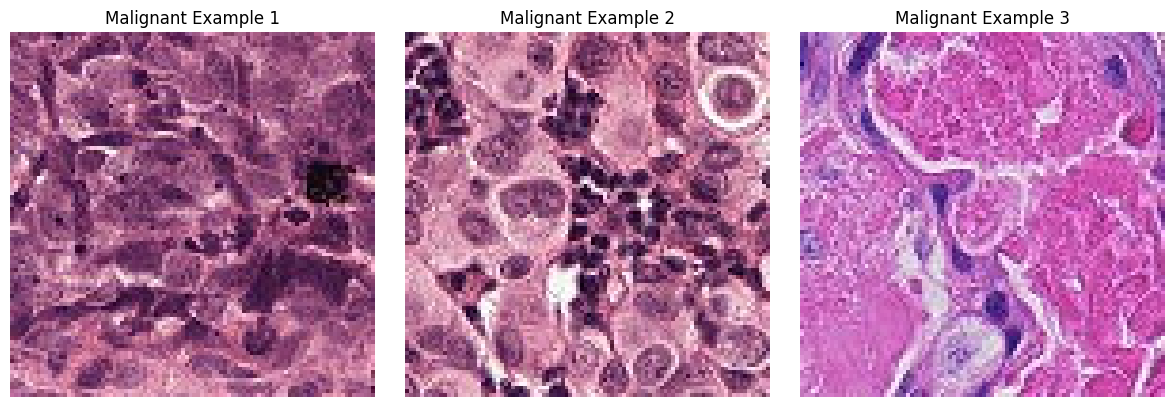

In [8]:
malignant_df = df[df['label'] == 1].sample(3)  

fig, axes = plt.subplots(1, 3, figsize=(12, 4))  

for i, (_, row) in enumerate(malignant_df.iterrows()):
    img_path = train_path + row['file']
    img = plt.imread(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Malignant Example {i+1}')

plt.tight_layout()
plt.show()

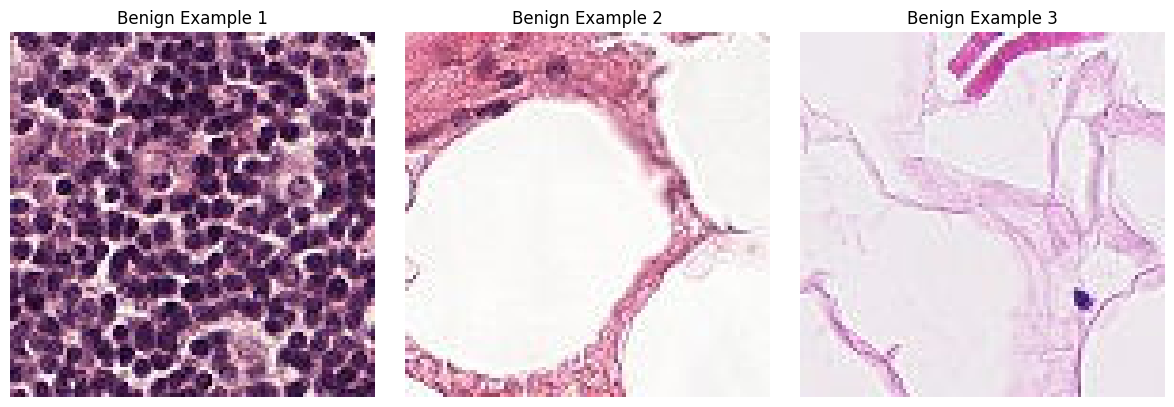

In [9]:
benign_df = df[df['label'] == 0].sample(3)  # Randomly select 3 benign examples

fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Create a figure with 3 subplots in a row

for i, (_, row) in enumerate(benign_df.iterrows()):
    img_path = train_path + row['file']
    img = plt.imread(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Benign Example {i+1}')

plt.tight_layout()
plt.show()

## Data Preparation

Split the dataset into training and validation datasets. All pixel information will be normalized. Images will be resized to 96,96 and data augments will be applied.



In [10]:
# Data Augmentation and Normalization
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42) 

train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

train_datagen = ImageDataGenerator(
    rescale            = 1./255,
    rotation_range     = 15,
    width_shift_range  = 0.1,
    height_shift_range = 0.1,
    shear_range        = 0.1,
    zoom_range         = 0.1,
    horizontal_flip    = True,
    fill_mode          = 'nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 256

train_generator = train_datagen.flow_from_dataframe(
    dataframe   = train_df,
    directory   = train_path,
    x_col       = 'file',
    y_col       = 'label',
    target_size = (96, 96),
    batch_size  = batch_size,
    class_mode  = 'binary'
)

# Validation generator using val_df
val_generator = val_datagen.flow_from_dataframe(
    dataframe   = val_df,
    directory   = train_path,
    x_col       = 'file',
    y_col       = 'label',
    target_size = (96, 96),
    batch_size  = batch_size,
    class_mode  = 'binary'
)

print("\nTraining Generator Details:")
print("Number of images in the training generator:", len(train_generator.filenames))

print("\nValidation Generator Details:")
print("Number of images in the validation generator:", len(val_generator.filenames))


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.

Training Generator Details:
Number of images in the training generator: 176020

Validation Generator Details:
Number of images in the validation generator: 44005


## Models (Architecture Exploration)

Two models will be evaluated for effectiveness - a custom CNN and Resnet50.

* Batch Size = 256
* Epoch = 10
* Learning Rate = 0.0001

### Model 1 - Custom CNN
The custom CNN architecture consists of a sequence of convolutional layers (Conv2D) followed by max pooling layers (MaxPooling2D), which learn to detect local patterns and features in the input images. The first convolutional layer has 32 filters with a kernel size of (3, 3) and learns low-level features, while the subsequent layers have 64 and 128 filters, capturing increasingly complex patterns specific to the metastatic cancer cells. Max pooling layers downsample the spatial dimensions, reduce computational complexity, and provide translation invariance. The Flatten layer converts the 2D feature maps into a 1D vector, followed by dense layers with 128 and 1 units for classification. The 'relu' activation function introduces non-linearity, and the 'sigmoid' activation in the final layer outputs the probability of the input belonging to the positive class. A Dropout layer with a rate of 0.5 is used to prevent overfitting by randomly setting a fraction of the input units to 0 during training, encouraging the model to learn robust representations.


In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

    
optimizer = Adam(learning_rate=0.00001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    
class LearningRateLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        current_lr = lr if isinstance(lr, float) else lr.numpy()
        print(f"Epoch {epoch+1}: Learning Rate is {current_lr}")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, min_lr=0.000001, verbose=1)

epochs = 10
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = val_generator.n // val_generator.batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[LearningRateLogger(), reduce_lr]
)

test_loss, test_accuracy = model.evaluate(val_generator, steps=validation_steps)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1: Learning Rate is 9.999999747378752e-06
Epoch 1/10
687/687 [==============================] - 247s 359ms/step - loss: 0.5944 - accuracy: 0.6808 - val_loss: 0.5504 - val_accuracy: 0.7493 - lr: 1.0000e-05
Epoch 2: Learning Rate is 9.999999747378752e-06
Epoch 2/10
687/687 [==============================] - 250s 364ms/step - loss: 0.4905 - accuracy: 0.7772 - val_loss: 0.5735 - val_accuracy: 0.7506 - lr: 1.0000e-05
Epoch 3: Learning Rate is 9.999999747378752e-06
Epoch 3/10
687/687 [==============================] - ETA: 0s - loss: 0.4772 - accuracy: 0.7847
Epoch 3: ReduceLROnPlateau reducing learning rate to 7.999999797903002e-06.
687/687 [==============================] - 255s 370ms/step - loss: 0.4772 - accuracy: 0.7847 - val_loss: 0.5854 - val_accuracy: 0.7452 - lr: 1.0000e-05
Epoch 4: Learning Rate is 7.999999979801942e-06
Epoch 4/10
687/687 [==============================] - 253s 368ms/step - loss: 0.4711 - accuracy: 0.7878 - val_loss: 0.5848 - val_accuracy: 0.7444 - lr: 8.0000

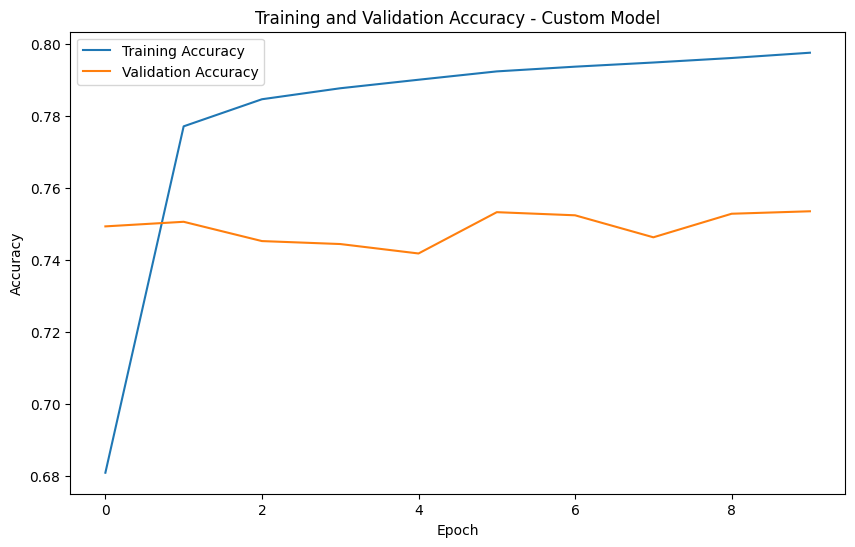

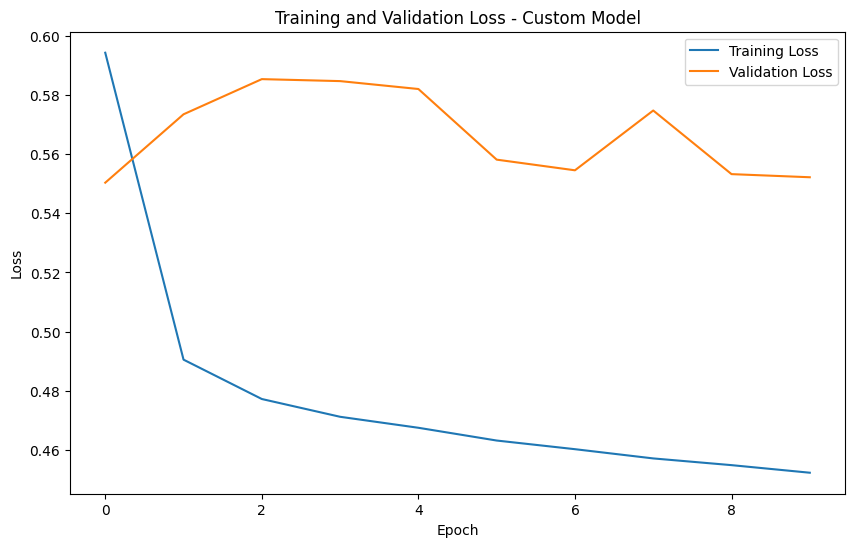

In [37]:
history_custom = history

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy - Custom Model')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Custom Model')
plt.legend()
plt.show()

#### Analysis

Based on the graphs above, the custom CNN is not converging smoothly based on the validation metrics, however the training curves are smooth. It appears like the model may be prone to overfitting.

### Model 2 - Resnet50 
Fine-tuning the pre-trained ResNet50 model involves retraining its layers alongside the additional classification layers. This approach allows the model to adapt its pre-learned features to the specific binary classification task. To fine-tune ResNet50, the layers of the base model are made trainable, and a lower learning rate is used to prevent large weight updates that could destroy the pre-learned features. Fine-tuning enables the model to leverage the powerful feature extraction capabilities of ResNet50 while tailoring it to the specific requirements of the binary classification problem of cancer detection.

In [33]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.00001)


model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

class LearningRateLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        current_lr = lr if isinstance(lr, float) else lr.numpy()
        print(f"Epoch {epoch+1}: Learning Rate is {current_lr}")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, min_lr=0.000001, verbose=1)

epochs = 10
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = val_generator.n // val_generator.batch_size


history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[LearningRateLogger(), reduce_lr]
)

test_loss, test_accuracy = model.evaluate(val_generator, steps=validation_steps)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1: Learning Rate is 9.999999747378752e-06
Epoch 1/10
687/687 [==============================] - 277s 382ms/step - loss: 0.3867 - accuracy: 0.8292 - val_loss: 0.7687 - val_accuracy: 0.6742 - lr: 1.0000e-05
Epoch 2: Learning Rate is 9.999999747378752e-06
Epoch 2/10
687/687 [==============================] - 273s 397ms/step - loss: 0.2535 - accuracy: 0.8982 - val_loss: 0.2267 - val_accuracy: 0.9122 - lr: 1.0000e-05
Epoch 3: Learning Rate is 9.999999747378752e-06
Epoch 3/10
687/687 [==============================] - 254s 370ms/step - loss: 0.2102 - accuracy: 0.9180 - val_loss: 0.2079 - val_accuracy: 0.9210 - lr: 1.0000e-05
Epoch 4: Learning Rate is 9.999999747378752e-06
Epoch 4/10
687/687 [==============================] - 256s 372ms/step - loss: 0.1843 - accuracy: 0.9297 - val_loss: 0.1941 - val_accuracy: 0.9280 - lr: 1.0000e-05
Epoch 5: Learning Rate is 9.999999747378752e-06
Epoch 5/10
687/687 [==============================] - 250s 363ms/step - loss: 0.1667 - accuracy: 0.9369 - va

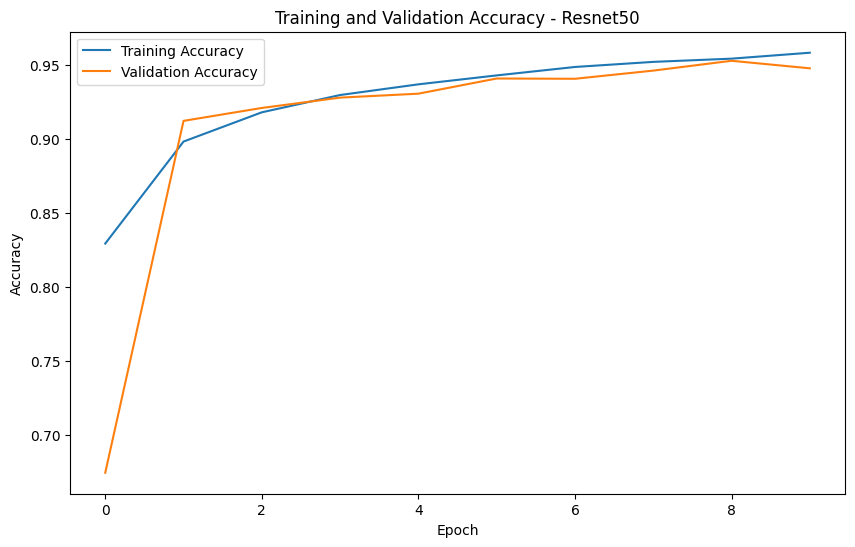

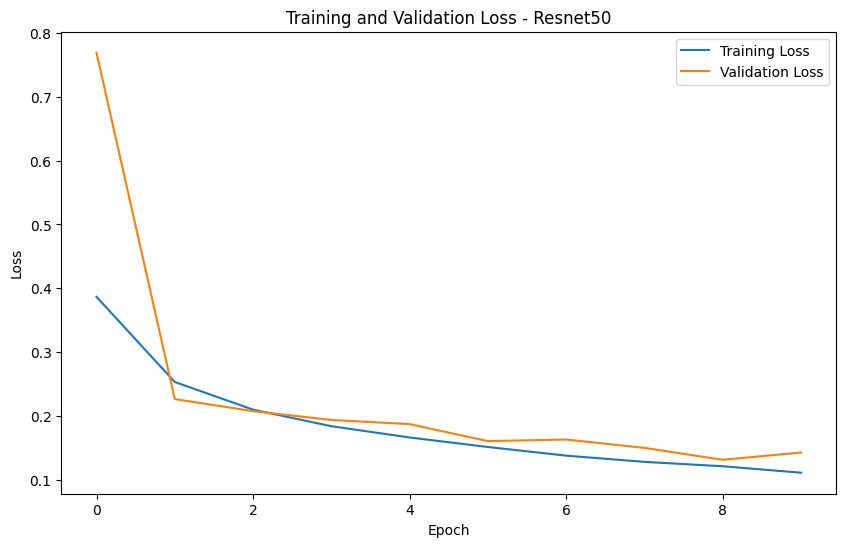

In [34]:
history_resnet50 = history

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy - Resnet50')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Resnet50')
plt.legend()
plt.show()

#### Analysis - Resnet50

Fine-tuning Resnet50 appears to have had a better result than the custom CNN. Resnet50 will be tuned for the submission

## Results and Analysis

Experiments adjusting the parameters of the training

### Experiment 1
* Reduce Batch Size to 64

In [15]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau

batch_size = 64
epochs = 10

train_generator = train_datagen.flow_from_dataframe(
    dataframe   = train_df,
    directory   = train_path,
    x_col       = 'file',
    y_col       = 'label',
    target_size = (96, 96),
    batch_size  = batch_size,
    class_mode  = 'binary'
)

# Validation generator using val_df
val_generator = val_datagen.flow_from_dataframe(
    dataframe   = val_df,
    directory   = train_path,
    x_col       = 'file',
    y_col       = 'label',
    target_size = (96, 96),
    batch_size  = batch_size,
    class_mode  = 'binary'
)

##############################################################################################
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.00001)


model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

class LearningRateLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        current_lr = lr if isinstance(lr, float) else lr.numpy()
        print(f"Epoch {epoch+1}: Learning Rate is {current_lr}")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, min_lr=0.000001, verbose=1)

##############################################################################################

steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = val_generator.n // val_generator.batch_size


history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[LearningRateLogger(), reduce_lr]
)

test_loss, test_accuracy = model.evaluate(val_generator, steps=validation_steps)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1: Learning Rate is 9.999999747378752e-06
Epoch 1/10


2024-04-23 03:30:41.109748: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90000
2024-04-23 03:30:42.550813: I external/local_xla/xla/service/service.cc:168] XLA service 0x72d928a691a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-23 03:30:42.550841: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-04-23 03:30:42.550849: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-04-23 03:30:42.555184: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713843042.605334   62695 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2750/2750 [==============================] - 299s 102ms/step - loss: 0.3421 - accuracy: 0.8529 - val_loss: 0.2806 - val_accuracy: 0.8873 - lr: 1.0000e-05
Epoch 2: Learning Rate is 9.999999747378752e-06
Epoch 2/10
2750/2750 [==============================] - 267s 97ms/step - loss: 0.2232 - accuracy: 0.9131 - val_loss: 0.2272 - val_accuracy: 0.9132 - lr: 1.0000e-05
Epoch 3: Learning Rate is 9.999999747378752e-06
Epoch 3/10
2750/2750 [==============================] - 266s 97ms/step - loss: 0.1862 - accuracy: 0.9285 - val_loss: 0.1805 - val_accuracy: 0.9328 - lr: 1.0000e-05
Epoch 4: Learning Rate is 9.999999747378752e-06
Epoch 4/10
2750/2750 [==============================] - 266s 97ms/step - loss: 0.1606 - accuracy: 0.9397 - val_loss: 0.1761 - val_accuracy: 0.9367 - lr: 1.0000e-05
Epoch 5: Learning Rate is 9.999999747378752e-06
Epoch 5/10
2750/2750 [==============================] - 265s 96ms/step - loss: 0.1440 - accuracy: 0.9458 - val_loss: 0.1359 - val_accuracy: 0.9491 - lr: 1.0000e-0

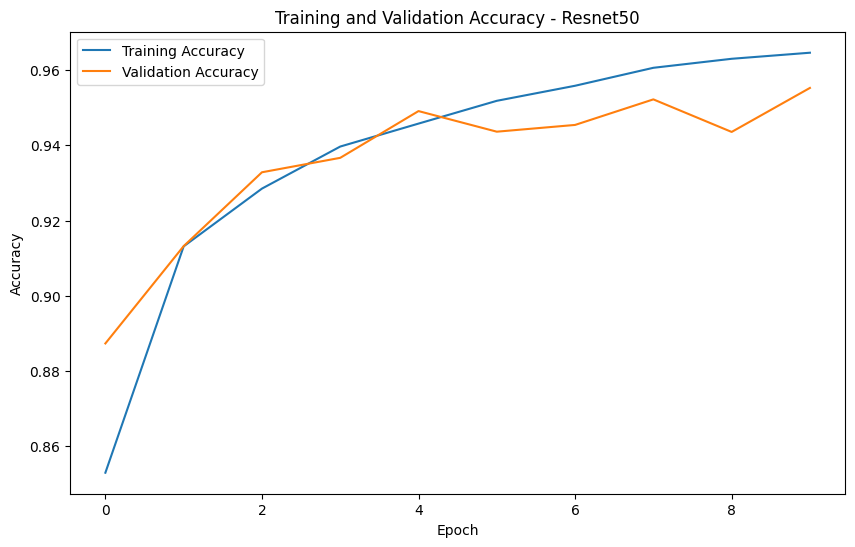

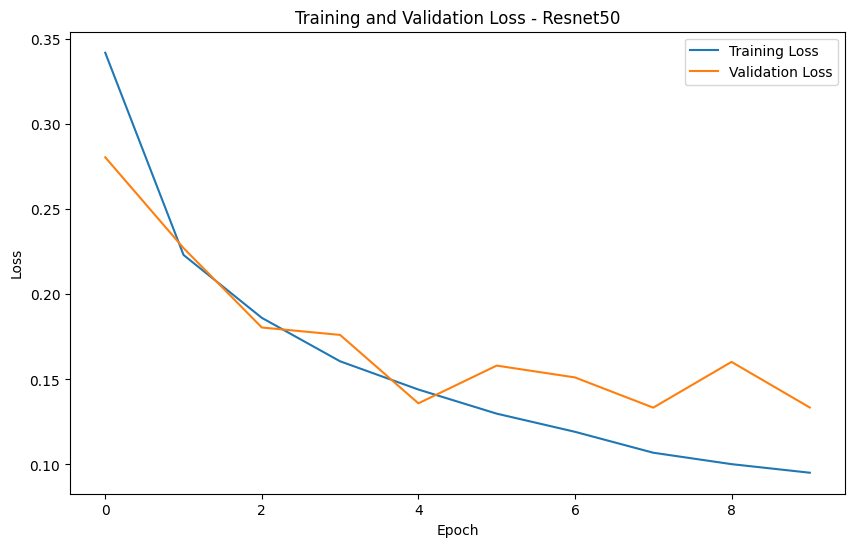

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy - Resnet50')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Resnet50')
plt.legend()
plt.show()

### Experiment 2
* Batch Size = 32
* Learning Rate = 0.000005
* Epochs = 20

In [13]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau

batch_size = 32
epochs = 20

train_generator = train_datagen.flow_from_dataframe(
    dataframe   = train_df,
    directory   = train_path,
    x_col       = 'file',
    y_col       = 'label',
    target_size = (96, 96),
    batch_size  = batch_size,
    class_mode  = 'binary'
)

# Validation generator using val_df
val_generator = val_datagen.flow_from_dataframe(
    dataframe   = val_df,
    directory   = train_path,
    x_col       = 'file',
    y_col       = 'label',
    target_size = (96, 96),
    batch_size  = batch_size,
    class_mode  = 'binary'
)

##############################################################################################
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.000005)


model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

class LearningRateLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        current_lr = lr if isinstance(lr, float) else lr.numpy()
        print(f"Epoch {epoch+1}: Learning Rate is {current_lr}")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1, min_lr=0.000001, verbose=1)

##############################################################################################

steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = val_generator.n // val_generator.batch_size


history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    verbose=2,
    callbacks=[LearningRateLogger(), reduce_lr]
)

test_loss, test_accuracy = model.evaluate(val_generator, steps=validation_steps)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


2024-04-23 15:01:59.025575: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 15:01:59.025860: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 15:01:59.026060: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1: Learning Rate is 4.999999873689376e-06
Epoch 1/20


2024-04-23 15:02:07.607239: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90000
2024-04-23 15:02:08.917746: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ddbcc495520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-23 15:02:08.917768: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-04-23 15:02:08.917774: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-04-23 15:02:08.921923: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713884528.973891   80172 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5500/5500 - 300s - loss: 0.3898 - accuracy: 0.8280 - val_loss: 0.2911 - val_accuracy: 0.8839 - lr: 5.0000e-06 - 300s/epoch - 54ms/step
Epoch 2: Learning Rate is 4.999999873689376e-06
Epoch 2/20
5500/5500 - 271s - loss: 0.2645 - accuracy: 0.8932 - val_loss: 0.2445 - val_accuracy: 0.9097 - lr: 5.0000e-06 - 271s/epoch - 49ms/step
Epoch 3: Learning Rate is 4.999999873689376e-06
Epoch 3/20
5500/5500 - 277s - loss: 0.2217 - accuracy: 0.9137 - val_loss: 0.2249 - val_accuracy: 0.9183 - lr: 5.0000e-06 - 277s/epoch - 50ms/step
Epoch 4: Learning Rate is 4.999999873689376e-06
Epoch 4/20
5500/5500 - 275s - loss: 0.1951 - accuracy: 0.9253 - val_loss: 0.1781 - val_accuracy: 0.9354 - lr: 5.0000e-06 - 275s/epoch - 50ms/step
Epoch 5: Learning Rate is 4.999999873689376e-06
Epoch 5/20
5500/5500 - 273s - loss: 0.1788 - accuracy: 0.9313 - val_loss: 0.1689 - val_accuracy: 0.9385 - lr: 5.0000e-06 - 273s/epoch - 50ms/step
Epoch 6: Learning Rate is 4.999999873689376e-06
Epoch 6/20

Epoch 6: ReduceLROnPlateau re

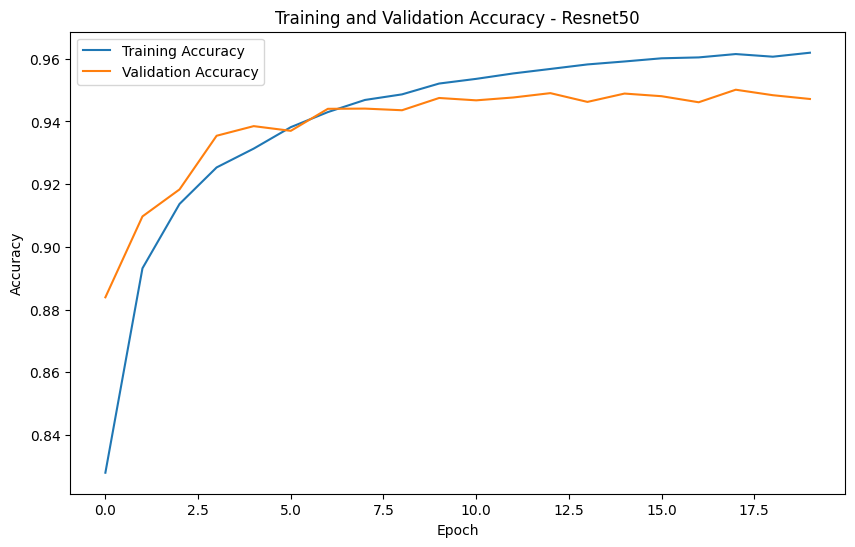

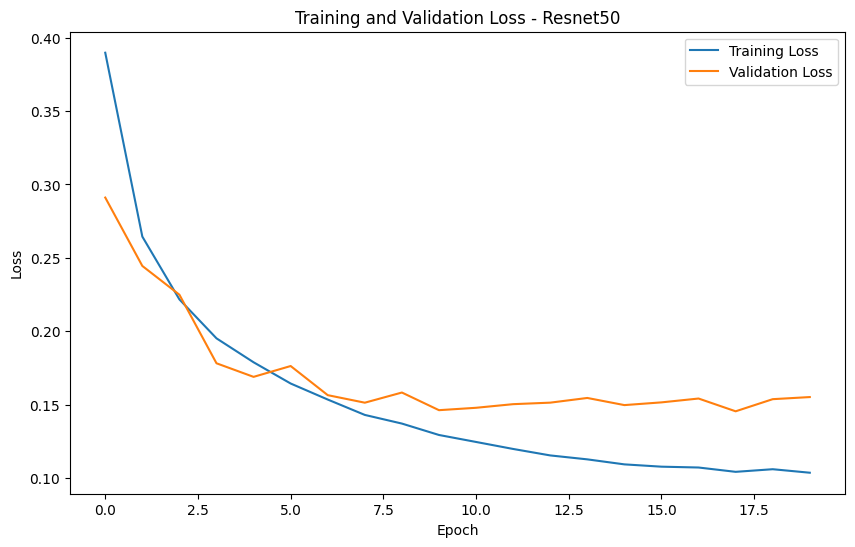

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy - Resnet50')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Resnet50')
plt.legend()
plt.show()

## Conclusion

Experiment 2 with Resenet-50 yielded a accuracy of 0.947. Based on the graph the model has plauted and there is a gap between training and validation pointing to a potential generalization issue. Further experiments with adjustments to the split between training and validation data and smaller batch sizes may yield better results.


In [34]:
test_df = pd.DataFrame(os.listdir(test_path), columns=['file'])


test_generator = val_datagen.flow_from_dataframe(
    dataframe   = test_df,
    directory   = test_path,
    x_col       = 'file',
    target_size = (96, 96),
    batch_size  = batch_size,
    class_mode  = None,
    subset=None,
    shuffle=False
)

prediction = model.predict(test_generator)

Found 57458 validated image filenames.
1796/1796 [==============================] - 24s 13ms/step


In [35]:
binary_pred = (prediction > 0.5).astype(int)
submission_df = pd.DataFrame()
submission_df['id'] = test_df['file'].apply(lambda x: x.split('.')[0])
submission_df['label'] = prediction.reshape(-1)
submission_df


,id,label
0,96f9a9c958609b34d6fcbca9218ebdffe285cc33,3.552127e-01
1,e93919a0f780b2215a71c84aef2727224f542f0c,7.205475e-04
2,5d9d7cf708598f03af1c84cbfd1a1c40d3d85ef1,5.197342e-04
3,1174dcaf5c2f3d8d2111411199bacc7864ecb18d,4.590045e-02
4,40fc17bd677d53c07468ec7779d784848601fcc5,9.434044e-09
...,...,...
57453,cf26d0048fc28b13fbdc339e4dcc05e99c729d07,7.137467e-04
57454,4f17ccf6bb439e32d3fa0867fa4ce96ed5ed1140,9.999815e-01
57455,cc1ed58eea9ea568d5fcfec94be2bccf103007ca,9.698986e-01
57456,0cdb0b8e5ed1b6f821e419349c43eed2cab63bb1,4.865330e-01


In [36]:
submission_df.to_csv('submission.csv', index=False)
